# Conversion rate challenge

## Part 0: Import libraries and load the dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier

In [2]:
df = pd.read_csv("conversion_data_train.csv")

## Part 1: EDA and Data Preprocessing

As the dataset is quite big, we will proceed with a sample of the dataset.

In [3]:
df_sample = df.sample(20000, random_state=0)
df_sample.head()

,country,age,new_user,source,total_pages_visited,converted
149371,US,20,1,Ads,7,0
221325,US,31,1,Seo,5,0
14016,US,28,0,Seo,4,0
257982,Germany,25,1,Ads,4,0
59983,US,44,0,Ads,7,0


In [4]:
print("Display of dataset:\n")
display(df_sample.head())
print('Basics statistics:\n')
display(df_sample.describe(include='all'))
print('Percentage of missing values:\n')
missing_percentage = df_sample.isnull().sum() * 100 / len(df_sample)
display(missing_percentage)

Display of dataset:



,country,age,new_user,source,total_pages_visited,converted
149371,US,20,1,Ads,7,0
221325,US,31,1,Seo,5,0
14016,US,28,0,Seo,4,0
257982,Germany,25,1,Ads,4,0
59983,US,44,0,Ads,7,0


Basics statistics:



,country,age,new_user,source,total_pages_visited,converted
count,20000,20000.000000,20000.000000,20000,20000.000000,20000.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,11234,NaN,NaN,9852,NaN,NaN
mean,NaN,30.538600,0.679100,NaN,4.889400,0.033900
std,NaN,8.273212,0.466834,NaN,3.384397,0.180976
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


Percentage of missing values:



country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

Let's see the correlation between the features.

<Axes: >

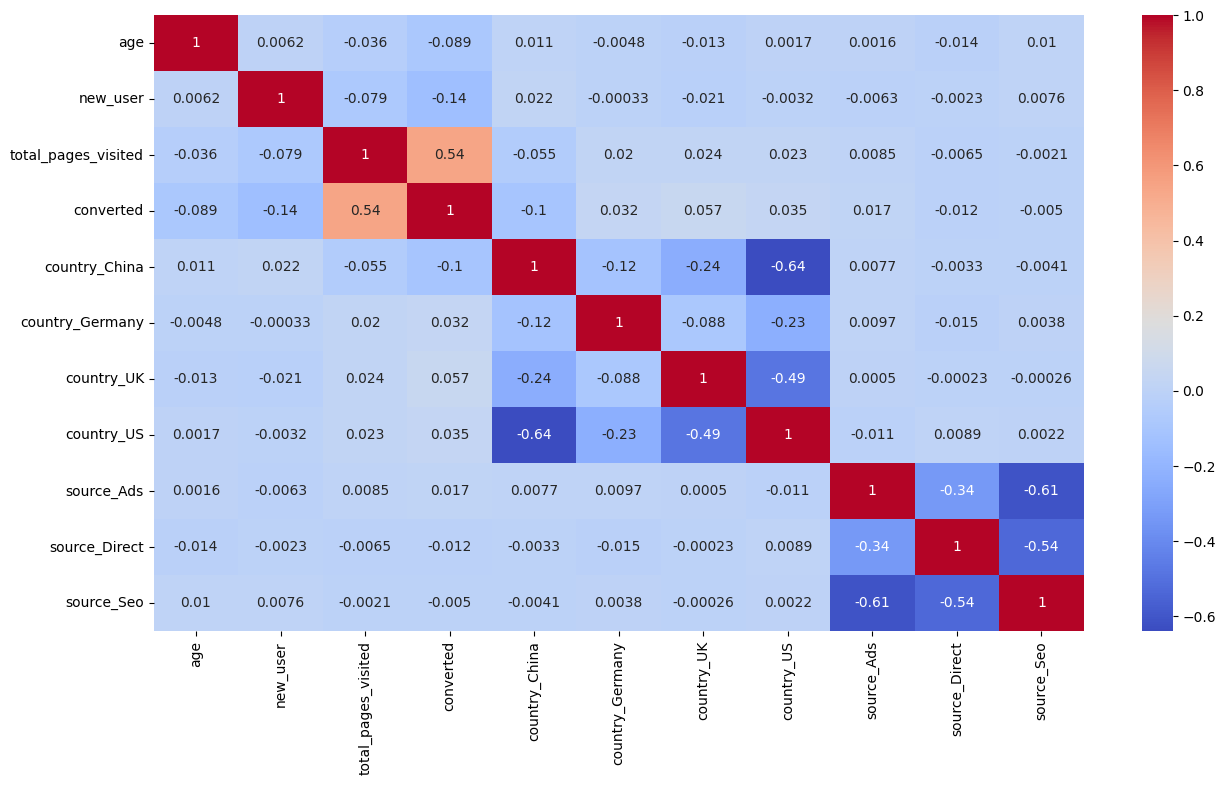

In [5]:
df_encoded = pd.get_dummies(df_sample, columns=['country', 'source'])
correlation_matrix = df_encoded.corr()
plt.figure(figsize=(15,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

We can see that the most relevant feature is "total_pages_visited".

Now let's do some preprocessing and get the names of numeric/categorical features.

In [6]:
# Separating the features and the target.
features_list = [c for c in df_sample.columns if c != "converted"]
target_variable = "converted"

X = df_sample.loc[:,features_list]
Y = df_sample.loc[:,target_variable]

print(f'X :\n{X.head()}')
print(f'Y :\n{Y.head()}')

X :
        country  age  new_user source  total_pages_visited
149371       US   20         1    Ads                    7
221325       US   31         1    Seo                    5
14016        US   28         0    Seo                    4
257982  Germany   25         1    Ads                    4
59983        US   44         0    Ads                    7
Y :
149371    0
221325    0
14016     0
257982    0
59983     0
Name: converted, dtype: int64


In [7]:
#Dividing into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

In [8]:
numeric_features = []
categorical_features = []

for i,t in X.dtypes.items():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Numeric features: ', numeric_features)
print('Categorical features: ', categorical_features)

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
])

print("Performing preprocessings on the features")
print(df_sample.head())
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

Numeric features:  ['age', 'new_user', 'total_pages_visited']
Categorical features:  ['country', 'source']
Performing preprocessings on the features
        country  age  new_user source  total_pages_visited  converted
149371       US   20         1    Ads                    7          0
221325       US   31         1    Seo                    5          0
14016        US   28         0    Seo                    4          0
257982  Germany   25         1    Ads                    4          0
59983        US   44         0    Ads                    7          0


Let's train a baseline model.

In [9]:
classifier = LogisticRegression() 
classifier.fit(X_train, Y_train)

Y_train_pred = classifier.predict(X_train)
Y_test_pred = classifier.predict(X_test)

In [10]:
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7430910951893552
f1-score on test set :  0.8093385214007782


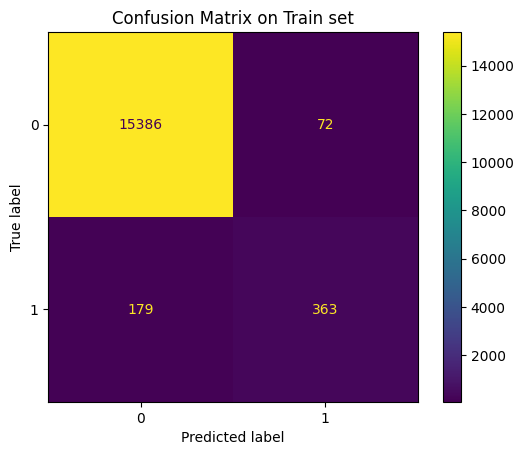

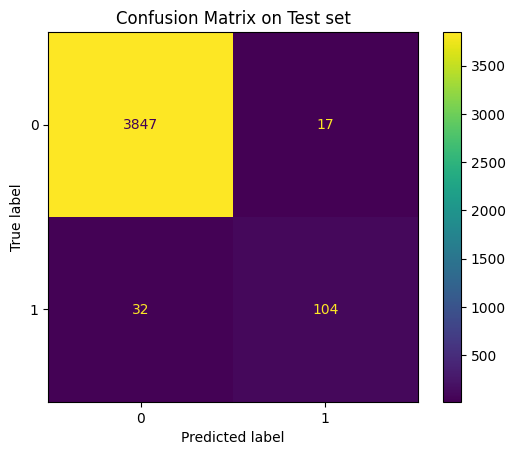

In [11]:
_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Train set") 
ConfusionMatrixDisplay.from_estimator(classifier, X_train, Y_train, ax=ax) 
plt.show()

_ , ax = plt.subplots()
ax.set(title="Confusion Matrix on Test set")
ConfusionMatrixDisplay.from_estimator(classifier, X_test, Y_test, ax=ax) 
plt.show()

The baseline model reaches a f1-score of almost 81%.

Let's try other models to see if the f1-score improves.

In [12]:
svc = SVC()
rf = RandomForestClassifier()

svc.fit(X_train, Y_train)
rf.fit(X_train, Y_train)

Y_train_pred_svc = svc.predict(X_train)
Y_train_pred_rf = rf.predict(X_train)

Y_test_pred_svc = svc.predict(X_test)
Y_test_pred_rf = rf.predict(X_test)

print("f1-score svc on train set : ", f1_score(Y_train, Y_train_pred_svc))
print("f1-score svc on test set : ", f1_score(Y_test, Y_test_pred_svc))
print("f1-score rf on train set : ", f1_score(Y_train, Y_train_pred_rf))
print("f1-score rf on test set : ", f1_score(Y_test, Y_test_pred_rf))

f1-score svc on train set :  0.7335490830636463
f1-score svc on test set :  0.7933884297520662
f1-score rf on train set :  0.9119070667957405
f1-score rf on test set :  0.744360902255639


In [13]:
print("Grid search...")
svc = SVC()

params = {
    'C': [0.1, 1, 10, 20],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

gridsearch = GridSearchCV(svc, param_grid = params, scoring="f1", cv = 5, verbose=1) 
gridsearch.fit(X_train, Y_train)

best_model_svc = gridsearch.best_estimator_
best_f1_score = gridsearch.best_score_

Y_pred = best_model_svc.predict(X_test)
test_f1_score_svc = f1_score(Y_test, Y_pred)

print("Best hyperparameters : ", gridsearch.best_params_)
print("Best F1-score: ", best_f1_score)
print("F1-score on the test set: ",test_f1_score_svc)

Grid search...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best hyperparameters :  {'C': 20, 'gamma': 'scale', 'kernel': 'linear'}
Best F1-score:  0.742465189457318
F1-score on the test set:  0.807843137254902


In [14]:
print("Grid search...")
rf = RandomForestClassifier()

params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

gridsearch = GridSearchCV(rf, param_grid = params, scoring="f1", cv = 5, verbose=1) 
gridsearch.fit(X_train, Y_train)

best_model_rf = gridsearch.best_estimator_
best_f1_score = gridsearch.best_score_

Y_pred = best_model_rf.predict(X_test)
test_f1_score_rf = f1_score(Y_test, Y_pred)

print("Best hyperparameters : ", gridsearch.best_params_)
print("Best F1-score: ", best_f1_score)
print("F1-score on the test set: ",test_f1_score_rf)

Grid search...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best hyperparameters :  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best F1-score:  0.7199534618504286
F1-score on the test set:  0.7686274509803922


## Part 2 : improve your model's f1-score on your test set

In [15]:
print("Grid search...")
logistic = LogisticRegression()

params = {
    'C': [0.1, 1, 5, 10, 20]
}
gridsearch = GridSearchCV(logistic, param_grid = params, scoring="f1", cv = 5, verbose=1) 
gridsearch.fit(X_train, Y_train)

best_model_log = gridsearch.best_estimator_
best_f1_score = gridsearch.best_score_

Y_pred = best_model_log.predict(X_test)
test_f1_score_log = f1_score(Y_test, Y_pred)

print("Best hyperparameters : ", gridsearch.best_params_)
print("Best F1-score: ", best_f1_score)
print("F1-score on the test set: ",test_f1_score_log)

Grid search...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best hyperparameters :  {'C': 10}
Best F1-score:  0.7511594195540071
F1-score on the test set:  0.8139534883720931


The Logistic Regression model is performing the best.

Let's try boosting and bagging.

In [16]:
logistic = LogisticRegression(max_iter = 1000) 
model = AdaBoostClassifier(estimator=logistic)

params = {
    'estimator__C': [0.1, 1, 5, 10, 20],
    'n_estimators': [5, 10, 20, 30] 
}
print(params)
gridsearch = GridSearchCV(model, param_grid = params, scoring="f1", cv = 5, verbose=1)
gridsearch.fit(X_train, Y_train)

adaboost_log = gridsearch.best_estimator_
best_f1_score = gridsearch.best_score_

Y_pred = adaboost_log.predict(X_test)
test_f1_score_boostlog = f1_score(Y_test, Y_pred)

print("Best hyperparameters : ", gridsearch.best_params_)
print("Best F1-score: ", best_f1_score)
print("F1-score on the test set: ",test_f1_score_boostlog)

{'estimator__C': [0.1, 1, 5, 10, 20], 'n_estimators': [5, 10, 20, 30]}
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters :  {'estimator__C': 10, 'n_estimators': 30}
Best F1-score:  0.751023489350252
F1-score on the test set:  0.803088803088803


In [17]:
logistic = LogisticRegression(max_iter = 1000) 
model = BaggingClassifier(estimator=logistic)

params = {
    'estimator__C': [0.1, 1, 5, 10, 20],  
    'n_estimators': [5, 10, 20, 30] 
}
print(params)
gridsearch = GridSearchCV(model, param_grid = params, scoring="f1", cv = 5, verbose=1) 
gridsearch.fit(X_train, Y_train)

bagging_log = gridsearch.best_estimator_
best_f1_score = gridsearch.best_score_

Y_pred = bagging_log.predict(X_test)
test_f1_score_baglog = f1_score(Y_test, Y_pred)

print("Best hyperparameters : ", gridsearch.best_params_)
print("Best F1-score: ", best_f1_score)
print("F1-score on the test set: ",test_f1_score_baglog)

{'estimator__C': [0.1, 1, 5, 10, 20], 'n_estimators': [5, 10, 20, 30]}
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters :  {'estimator__C': 20, 'n_estimators': 20}
Best F1-score:  0.7550287974672237
F1-score on the test set:  0.8108108108108107


Let's try voting.

In [18]:
voting = VotingClassifier(estimators=[("logistic", best_model_log), ("adaboost_log", adaboost_log), ("bagging_log", bagging_log), ("best_model_svc", best_model_svc)], voting='hard') # soft: use probabilities for voting
voting.fit(X_train, Y_train)

Y_pred = voting.predict(X_test)
test_f1_score_vot = f1_score(Y_test, Y_pred)
print("F1-score on test set:", test_f1_score_vot)

F1-score on test set: 0.8093385214007782


In [19]:
test_f1_scores = [test_f1_score_svc, test_f1_score_rf, test_f1_score_log, 
                  test_f1_score_boostlog, test_f1_score_baglog, test_f1_score_vot]

best_f1_score = max(test_f1_scores)

print("The best f1-score is: ", best_f1_score)

The best f1-score is:  0.8139534883720931


The best model is a logistic regression model with C = 10.

Now let's train our model on all the data.

In [20]:
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

best_model_log.fit(X,Y)

LogisticRegression(C=10)

## Part 3 : Predictions with the file data_test.csv.

In [21]:
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

X_without_labels = data_without_labels
X_without_labels

Prediction set (without labels) : (31620, 5)


,country,age,new_user,source,total_pages_visited
0,UK,28,0,Seo,16
1,UK,22,1,Direct,5
2,China,32,1,Seo,1
3,US,32,1,Ads,6
4,China,25,0,Seo,3
...,...,...,...,...,...
31615,Germany,25,1,Seo,3
31616,US,36,1,Ads,7
31617,UK,33,1,Seo,5
31618,UK,25,1,Seo,14


In [22]:
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.31139413 -1.44857632  3.30331968  0.          1.          0.
   0.          1.        ]
 [-1.03519831  0.69033297  0.03187797  0.          1.          0.
   1.          0.        ]
 [ 0.17114199  0.69033297 -1.1577372   0.          0.          0.
   0.          1.        ]
 [ 0.17114199  0.69033297  0.32928176  0.          0.          1.
   0.          0.        ]
 [-0.67329622 -1.44857632 -0.56292962  0.          0.          0.
   0.          1.        ]]


In [23]:
data = {
    'converted': best_model_log.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions.csv', index=False)